# Revisión de datos del viejo y nuevo Congreso

## Preparación

Abrir las tablas de datos históricos del Directorio Legislativo (2000-2018).

Crear columna con el nombre completo que concatene el campo nombre con el campo apellido y eliminar duplicados.

In [6]:
import pandas as pd
import unidecode
import warnings
warnings.filterwarnings('ignore')

diputados = pd.read_csv('data/diputados_2000_2018.csv')
diputados['nombre'] = diputados['diputado_nombre'] + " " + diputados['diputado_apellido']
diputados['nombre'] = diputados['nombre'].apply(lambda x: unidecode.unidecode(x.decode('utf-8')).lower())
diputados_todos = diputados.sort_values('diputado_mandatoFinal', ascending=False).groupby('nombre').first().reset_index()

senadores = pd.read_csv('data/senadores_2000_2018.csv')
senadores['nombre'] = senadores['datospersonales_nombre'] + " " + senadores['datospersonales_apellido']
senadores['nombre'] = senadores['nombre'].apply(lambda x: unidecode.unidecode(x.decode('utf-8')).lower())
senadores_todos = senadores.sort_values('datospersonales_mandatoFinal', ascending=False).groupby('nombre').first().reset_index()

Calcular edad.

In [7]:
# Función para calcular la edad

import numpy as np

def calculaEdad(datos, columna_fecha):
    datos['fecha_limpia'] = datos[columna_fecha].replace('NO RESPONDE', np.nan)
    datos['fecha_limpia'] = pd.to_datetime(datos['fecha_limpia'], errors='coerce')
    hoy = pd.Timestamp('now')
    datos['fecha_limpia'] = datos['fecha_limpia'].where(datos['fecha_limpia'] < hoy, datos['fecha_limpia'] -  np.timedelta64(100, 'Y'))
    datos['edad'] = (hoy - datos['fecha_limpia']).astype('<m8[Y]')

calculaEdad(diputados_todos, 'diputado_fechanacimiento')
calculaEdad(senadores_todos, 'datospersonales_fechanacimiento')

Abrir listado de precandidatos con corrección de nombres.

Dado que en varios casos se omite el uso del segundo nombre, se hizo una corrección usando distancias de Levenshtein e indicando manualmente las coincidencias en [este archivo](https://docs.google.com/spreadsheets/d/1MYXn653RUNsCIba9UrASMbzlbJBx0YZYb0b8mPf1Tpc/edit#gid=0).

In [8]:
listas = pd.read_csv('data/nombres_legisladores_match.csv', encoding="utf-8")

listas['nombre_final'] = listas.apply(lambda x: x['result_l'] if x['misma_persona'] == 'Si' else x['nombre'], axis=1)

Separar los legisladores vigentes de los del pasado a partir del año de su mandato final (2019 y 2021 para los diputados y 2019, 2021 y 2023 para senadores).

In [9]:
diputados_vigente = diputados_todos[diputados_todos['diputado_mandatoFinal'].isin([2019, 2021])]
diputados_pasado = diputados_todos[~diputados_todos['diputado_mandatoFinal'].isin([2019, 2021])]

senadores_vigente = senadores_todos[senadores_todos['datospersonales_mandatoFinal'].isin([2019, 2021, 2023])]
senadores_pasado = senadores_todos[~senadores_todos['datospersonales_mandatoFinal'].isin([2019, 2021, 2023])]

## Grupos de estudio

In [10]:
# Función para realizar gráficos de torta mas facilmente.

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

def graficosDeTorta(grilla, data):
    figure(figsize=(grilla[1]*grilla[2], grilla[0]*grilla[2]))
    
    for x in range(grilla[0]*grilla[1]):
        plt.subplot(grilla[0], grilla[1], x+1)
        counts = data[x]['data'].groupby(data[x]['groupby']).count()
        counts = counts.sort_values(counts.columns[0]).iloc[:, 1]
        labels = ['{} ({})'.format(xx[0], xx[1]) for xx in counts.reset_index().values]
        ax = counts.plot.pie(autopct='%1.0f%%', legend=False, title=data[x]['title'], labels=labels)
        ax.yaxis.set_label_text("")
    plt.show()

### Los que continúan, los que renuevan y los que se van
De los legisladores vigentes van a renovar los que estén presentes en el listado de precandidatos mientras los que no y que además terminan mandato en el 2019 dejan sus bancas.

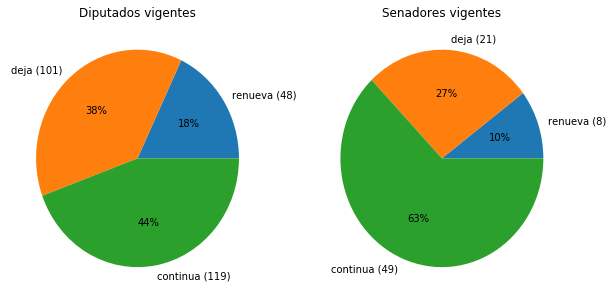

In [11]:
diputados_vigente['renueva'] = diputados_vigente['nombre'].isin(listas['nombre_final'])
senadores_vigente['renueva'] = senadores_vigente['nombre'].isin(listas['nombre_final'])

diputados_vigente['deja'] = (~diputados_vigente['renueva']) & (diputados_vigente['diputado_mandatoFinal'] == 2019)
senadores_vigente['deja'] = (~senadores_vigente['renueva']) & (senadores_vigente['datospersonales_mandatoFinal'] == 2019)

diputados_vigente['grupo'] = diputados_vigente.apply(lambda x: 'renueva' if x['renueva'] else 'deja' if x['deja'] else 'continua', axis=1)
senadores_vigente['grupo'] = senadores_vigente.apply(lambda x: 'renueva' if x['renueva'] else 'deja' if x['deja'] else 'continua', axis=1)

graficosDeTorta([1,2,5], [
    {'data': diputados_vigente, 'groupby': 'grupo', 'title': 'Diputados vigentes'},
    {'data': senadores_vigente, 'groupby': 'grupo', 'title': 'Senadores vigentes'},
])

### Los nuevos y los que vuelven
De los precandidatos consideramos que vuelven quienes no sean legisladores vigentes y esten en la base histórica del Directorio Legislativo.

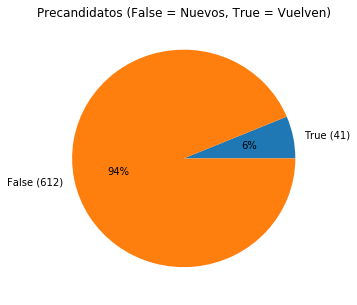

In [12]:
diputados_pasado['vuelve'] = diputados_pasado['nombre'].isin(listas['nombre_final'])
senadores_pasado['vuelve'] = senadores_pasado['nombre'].isin(listas['nombre_final'])

listas['vuelve'] = listas['nombre_final'].isin(pd.concat([senadores_pasado['nombre'], diputados_pasado['nombre']]))

graficosDeTorta([1,1,5], [{'data': listas, 'groupby': 'vuelve', 'title': 'Precandidatos (False = Nuevos, True = Vuelven)'}])

## Variables

Se evaluarán los grupos según las siguientes dimensiones:
* Género
* Distrito
* Bloque
* Edad
* Nivel de estudios
* Universidad
* Actividad privada previa
* Actividad pública previa

### Género
Para conocer la cantidad de legisladores por género y por grupo se utiliza la columna `diputado_sexo` de la tabla diputados y  la columna `datospersonales_sexo` de la tabla de senadores.

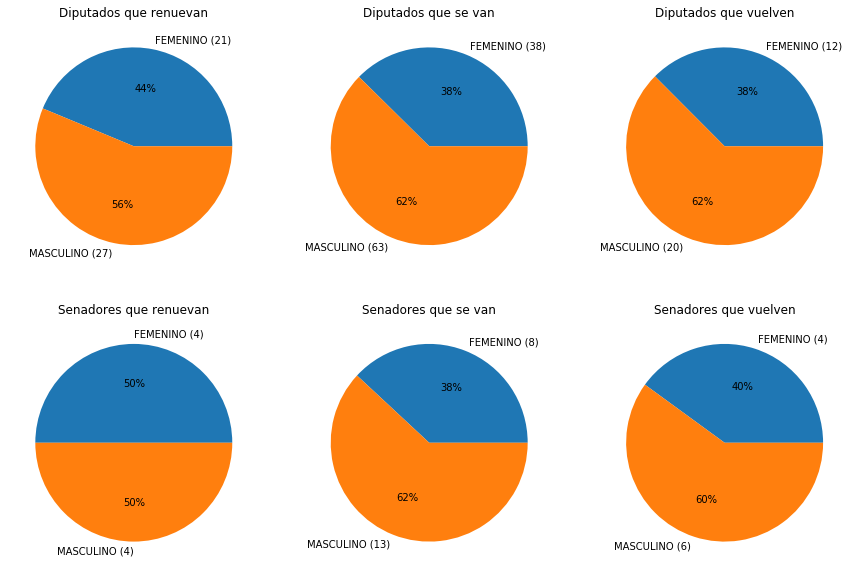

In [13]:
graficosDeTorta([2,3,5], [
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'renueva'], 'groupby': 'diputado_sexo',        'title': 'Diputados que renuevan'},
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'deja'],    'groupby': 'diputado_sexo',        'title': 'Diputados que se van'},
    {'data': diputados_pasado[diputados_pasado['vuelve']],               'groupby': 'diputado_sexo',        'title': 'Diputados que vuelven'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'renueva'], 'groupby': 'datospersonales_sexo', 'title': 'Senadores que renuevan'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'deja'],    'groupby': 'datospersonales_sexo', 'title': 'Senadores que se van'},
    {'data': senadores_pasado[senadores_pasado['vuelve']],               'groupby': 'datospersonales_sexo', 'title': 'Senadores que vuelven'}
])

### Distrito
Para conocer la cantidad de legisladores por distrito y por grupo se utiliza la columna `diputado_provincia` de la tabla diputados y  la columna `datospersonales_provincia` de la tabla de senadores.

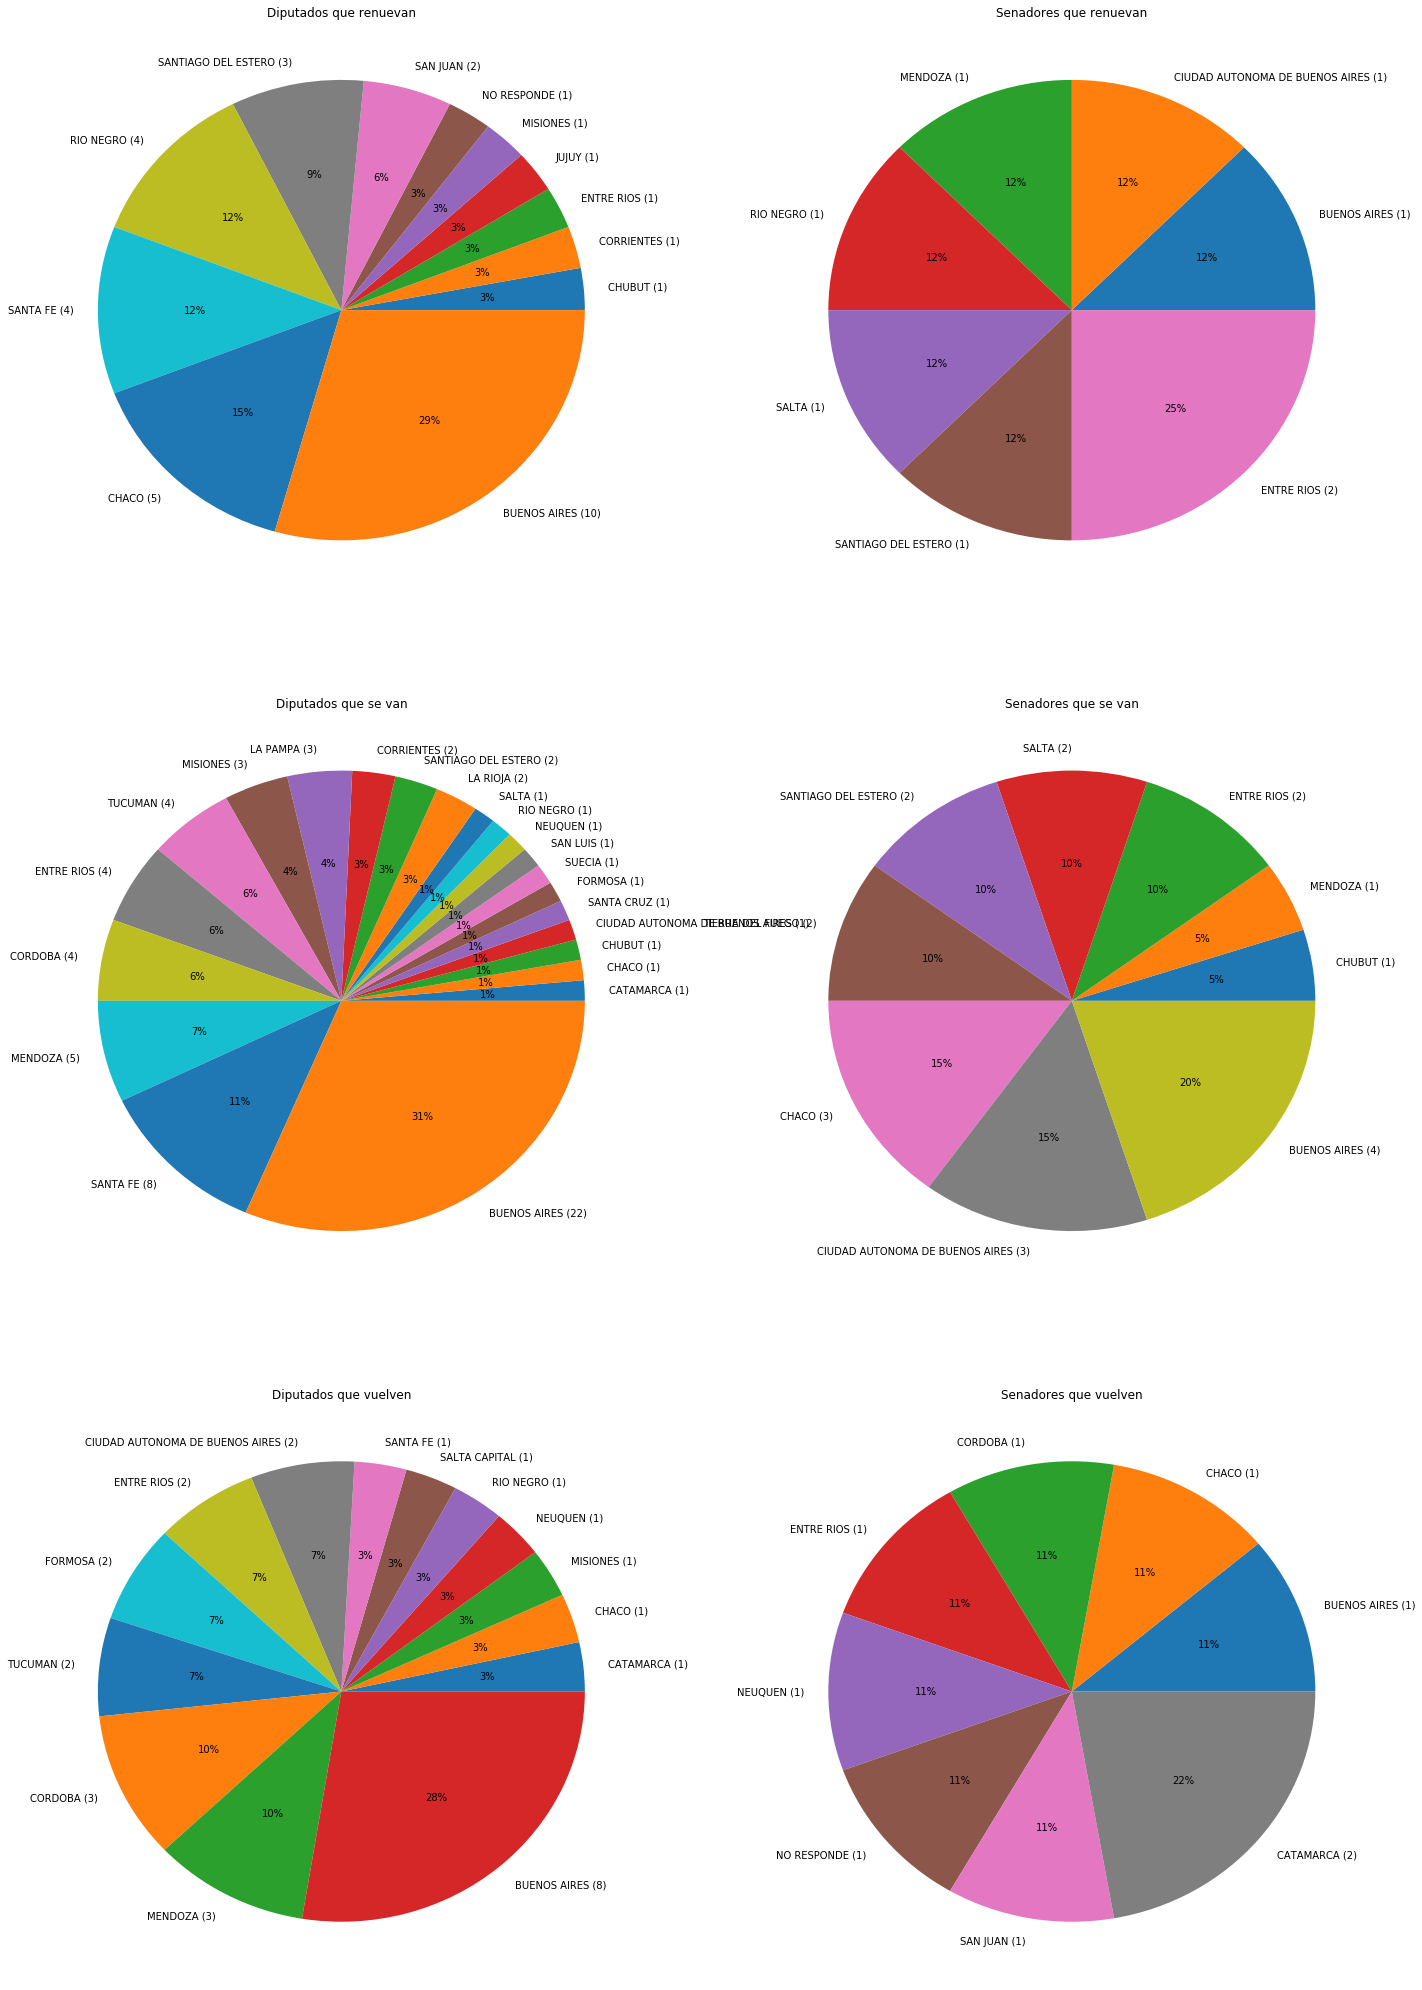

In [14]:
graficosDeTorta([3,2,12], [
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'renueva'], 'groupby': 'diputado_provincia',        'title': 'Diputados que renuevan'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'renueva'], 'groupby': 'datospersonales_provincia', 'title': 'Senadores que renuevan'},
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'deja'],    'groupby': 'diputado_provincia',        'title': 'Diputados que se van'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'deja'],    'groupby': 'datospersonales_provincia', 'title': 'Senadores que se van'},
    {'data': diputados_pasado[diputados_pasado['vuelve']],               'groupby': 'diputado_provincia',        'title': 'Diputados que vuelven'},
    {'data': senadores_pasado[senadores_pasado['vuelve']],               'groupby': 'datospersonales_provincia', 'title': 'Senadores que vuelven'}
])

### Bloque
Para conocer la cantidad de legisladores por bloque y por grupo se utiliza la columna `diputado_bloque` de la tabla diputados y  la columna `datospersonales_bloque` de la tabla de senadores.

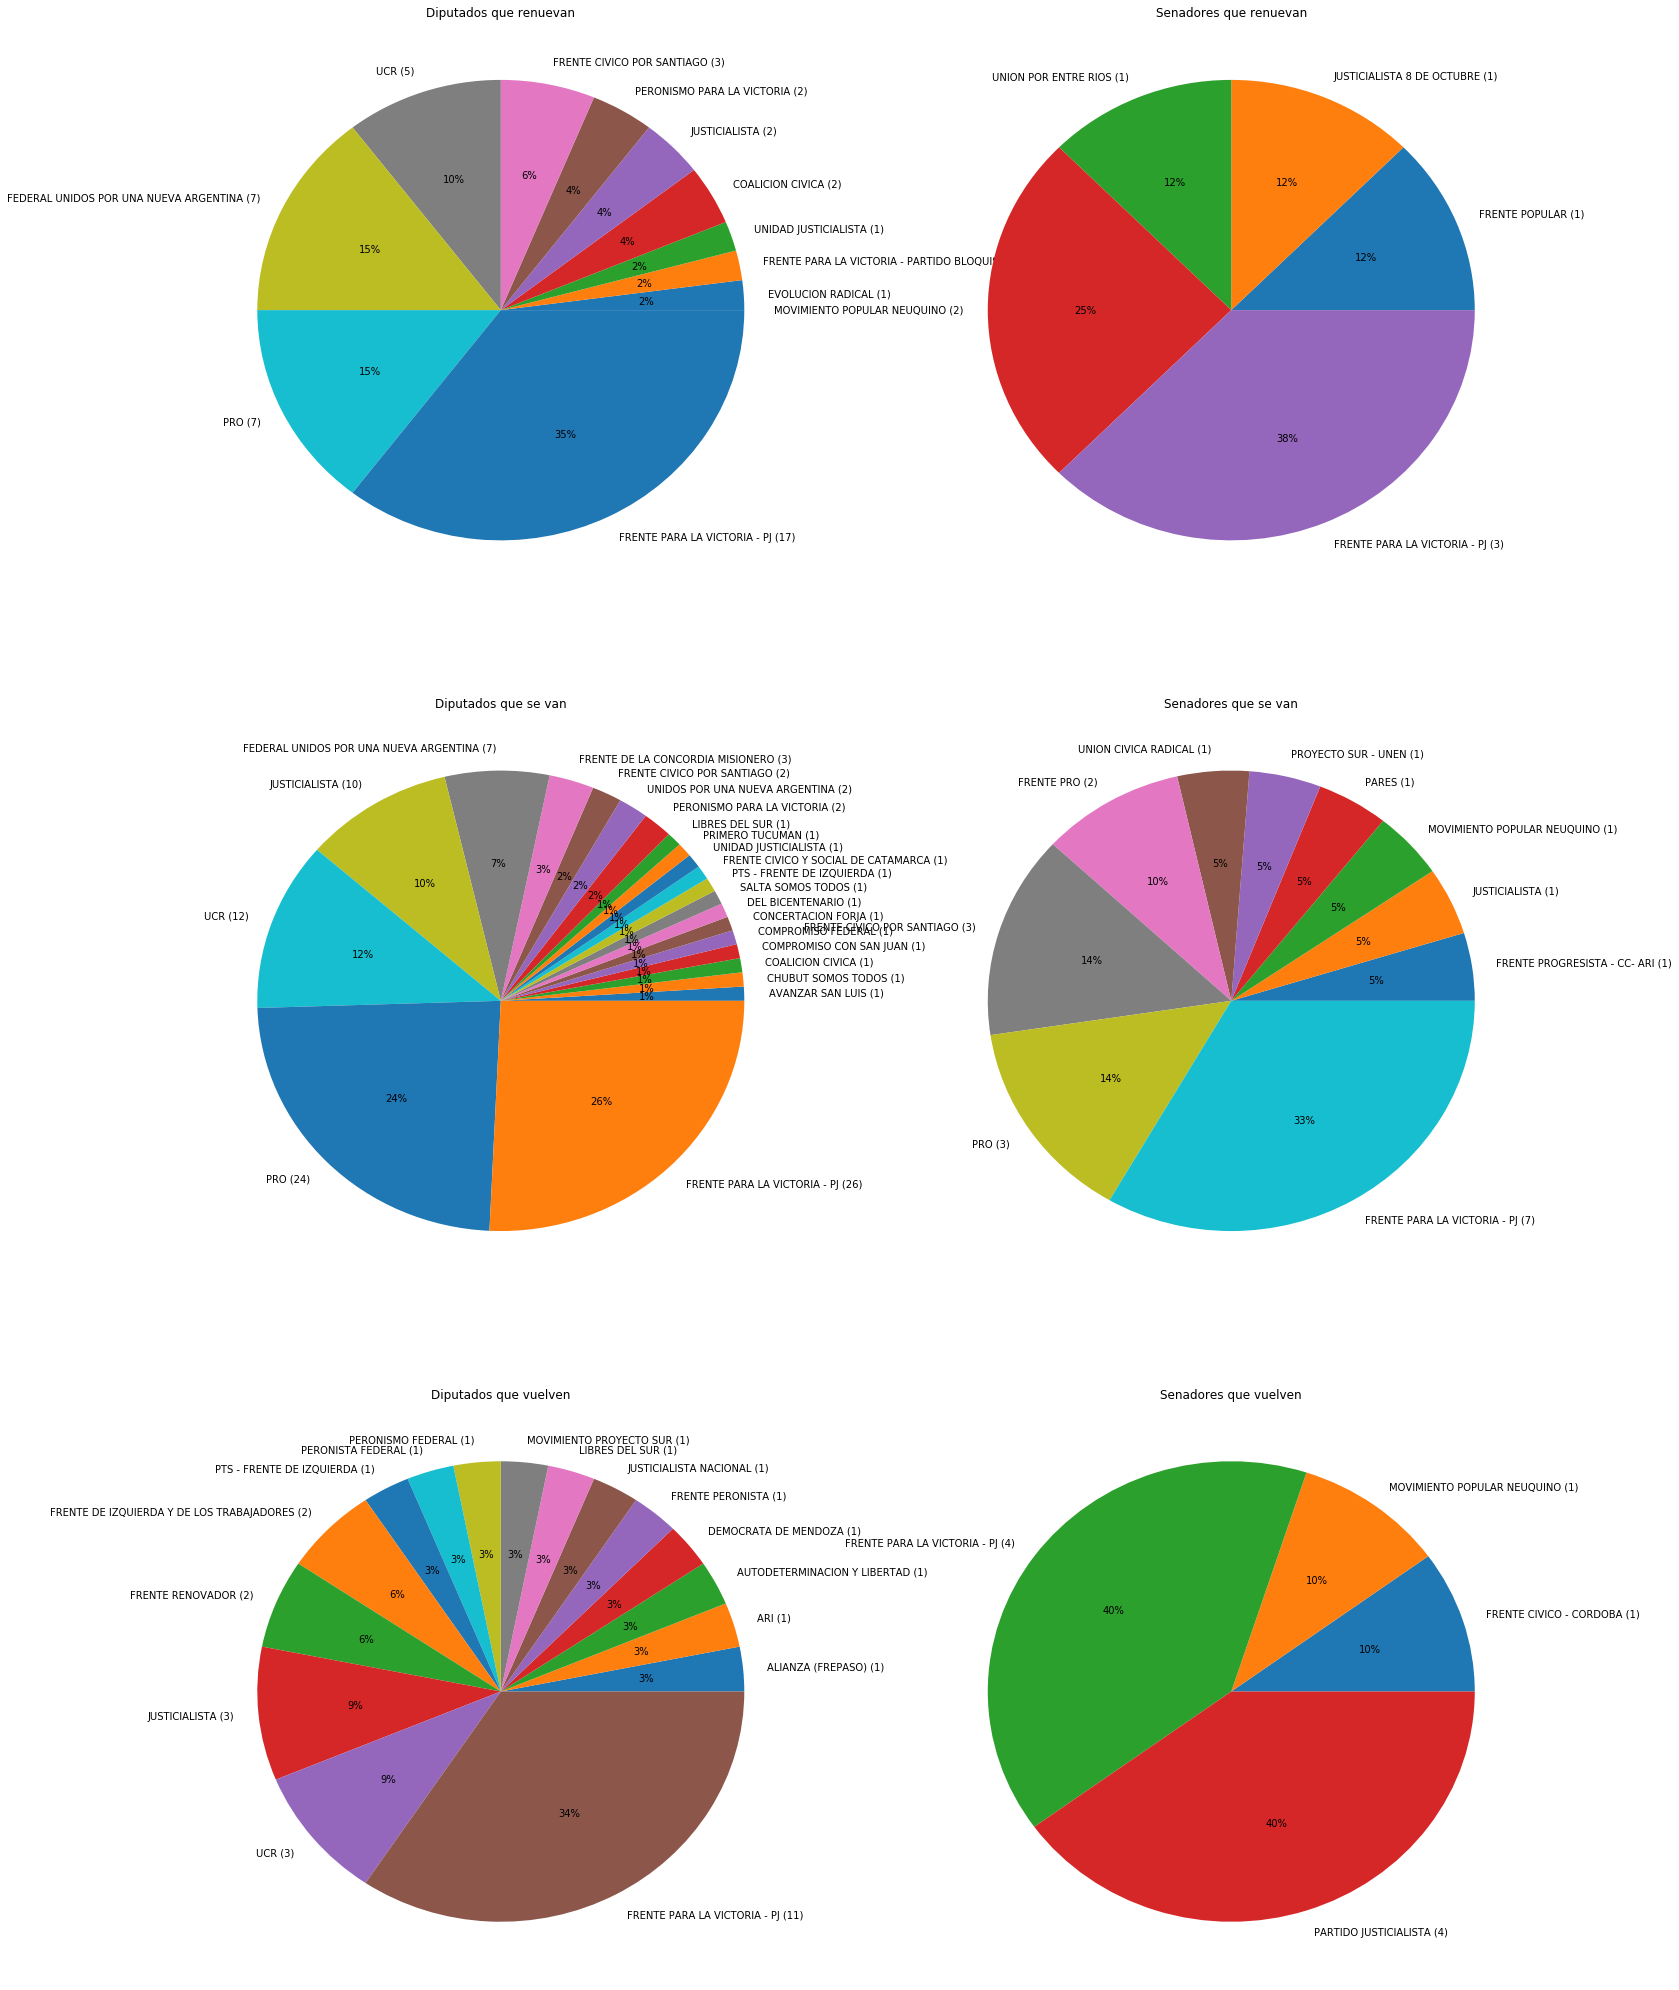

In [15]:
graficosDeTorta([3,2,12], [
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'renueva'], 'groupby': 'diputado_bloque',        'title': 'Diputados que renuevan'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'renueva'], 'groupby': 'datospersonales_bloque', 'title': 'Senadores que renuevan'},
    {'data': diputados_vigente[diputados_vigente['grupo'] == 'deja'],    'groupby': 'diputado_bloque',        'title': 'Diputados que se van'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'deja'],    'groupby': 'datospersonales_bloque', 'title': 'Senadores que se van'},
    {'data': diputados_pasado[diputados_pasado['vuelve']],               'groupby': 'diputado_bloque',        'title': 'Diputados que vuelven'},
    {'data': senadores_pasado[senadores_pasado['vuelve']],               'groupby': 'datospersonales_bloque', 'title': 'Senadores que vuelven'}
])

### Edad

Histograma de edades para cada grupo.

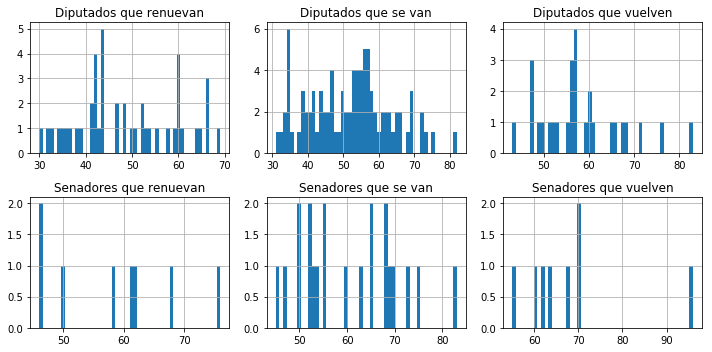

In [16]:
figure(figsize=(10, 5))
bins = 50

plt.subplot(2, 3, 1)
ax = diputados_vigente[diputados_vigente['grupo'] == 'renueva']['edad'].hist(bins=bins)
ax.title.set_text('Diputados que renuevan')

plt.subplot(2, 3, 2)
ax = diputados_vigente[diputados_vigente['grupo'] == 'deja']['edad'].hist(bins=bins)
ax.title.set_text('Diputados que se van')

plt.subplot(2, 3, 3)
ax = diputados_pasado[diputados_pasado['vuelve']]['edad'].hist(bins=bins)
ax.title.set_text('Diputados que vuelven')


plt.subplot(2, 3, 4)
ax = senadores_vigente[senadores_vigente['grupo'] == 'renueva']['edad'].hist(bins=bins)
ax.title.set_text('Senadores que renuevan')

plt.subplot(2, 3, 5)
ax = senadores_vigente[senadores_vigente['grupo'] == 'deja']['edad'].hist(bins=bins)
ax.title.set_text('Senadores que se van')

plt.subplot(2, 3, 6)
ax = senadores_pasado[senadores_pasado['vuelve']]['edad'].hist(bins=bins)
ax.title.set_text('Senadores que vuelven')

plt.tight_layout()
plt.show()

### Normalizar columnas

Las siguientes variables que son multiples por legislador, deben ser normalizadas para poder trabajarlas ya que se encuentran separadas por número.

In [17]:
#Función para normalizar columnas

def normalizarColumnas(datos):
    columnas = {}
    for string in datos.columns:
        ind = [int(s) for s in string if s.isdigit()][0]
        if ind in columnas.keys():
            columnas[ind].append(string)
        else:
            columnas[ind] = [string]
    dfs = []
    for cols in columnas.values():
#         print(cols)
        df = datos[cols]
        df.columns = [''.join([s for s in string if not s.isdigit()]) for string in columnas.values()[0]]
        df = df.replace(['NO RESPONDE', 'NO REALIZA', 'NO'], np.nan)
        df = df.dropna(how='all').reset_index()
        dfs.append(df)

    return pd.concat(dfs)

In [18]:
# Nivel de estudios
# Universidad
# columnas_estudios_dip = [col for col in diputados.columns if col.startswith('estudios')]
# columnas_estudios_sen = [col for col in diputados.columns if col.startswith('titulosacademicosobtenidos')]


# Actividad privada previa
# columnas_actprivada_dip = [col for col in diputados.columns if col.startswith('actprivada') and col != 'actprivada_reportaingresosllenar']
# columnas_actprivada_sen = [col for col in diputados.columns if col.startswith('actividadprivadaprevia')]


# Actividad pública previa
# columnas_actpublica_dip = [col for col in diputados.columns if col.startswith('actpublica')]
# columnas_actpublica_sen = [col for col in diputados.columns if col.startswith('actividadpublicaprevia')]

### Nivel de estudios

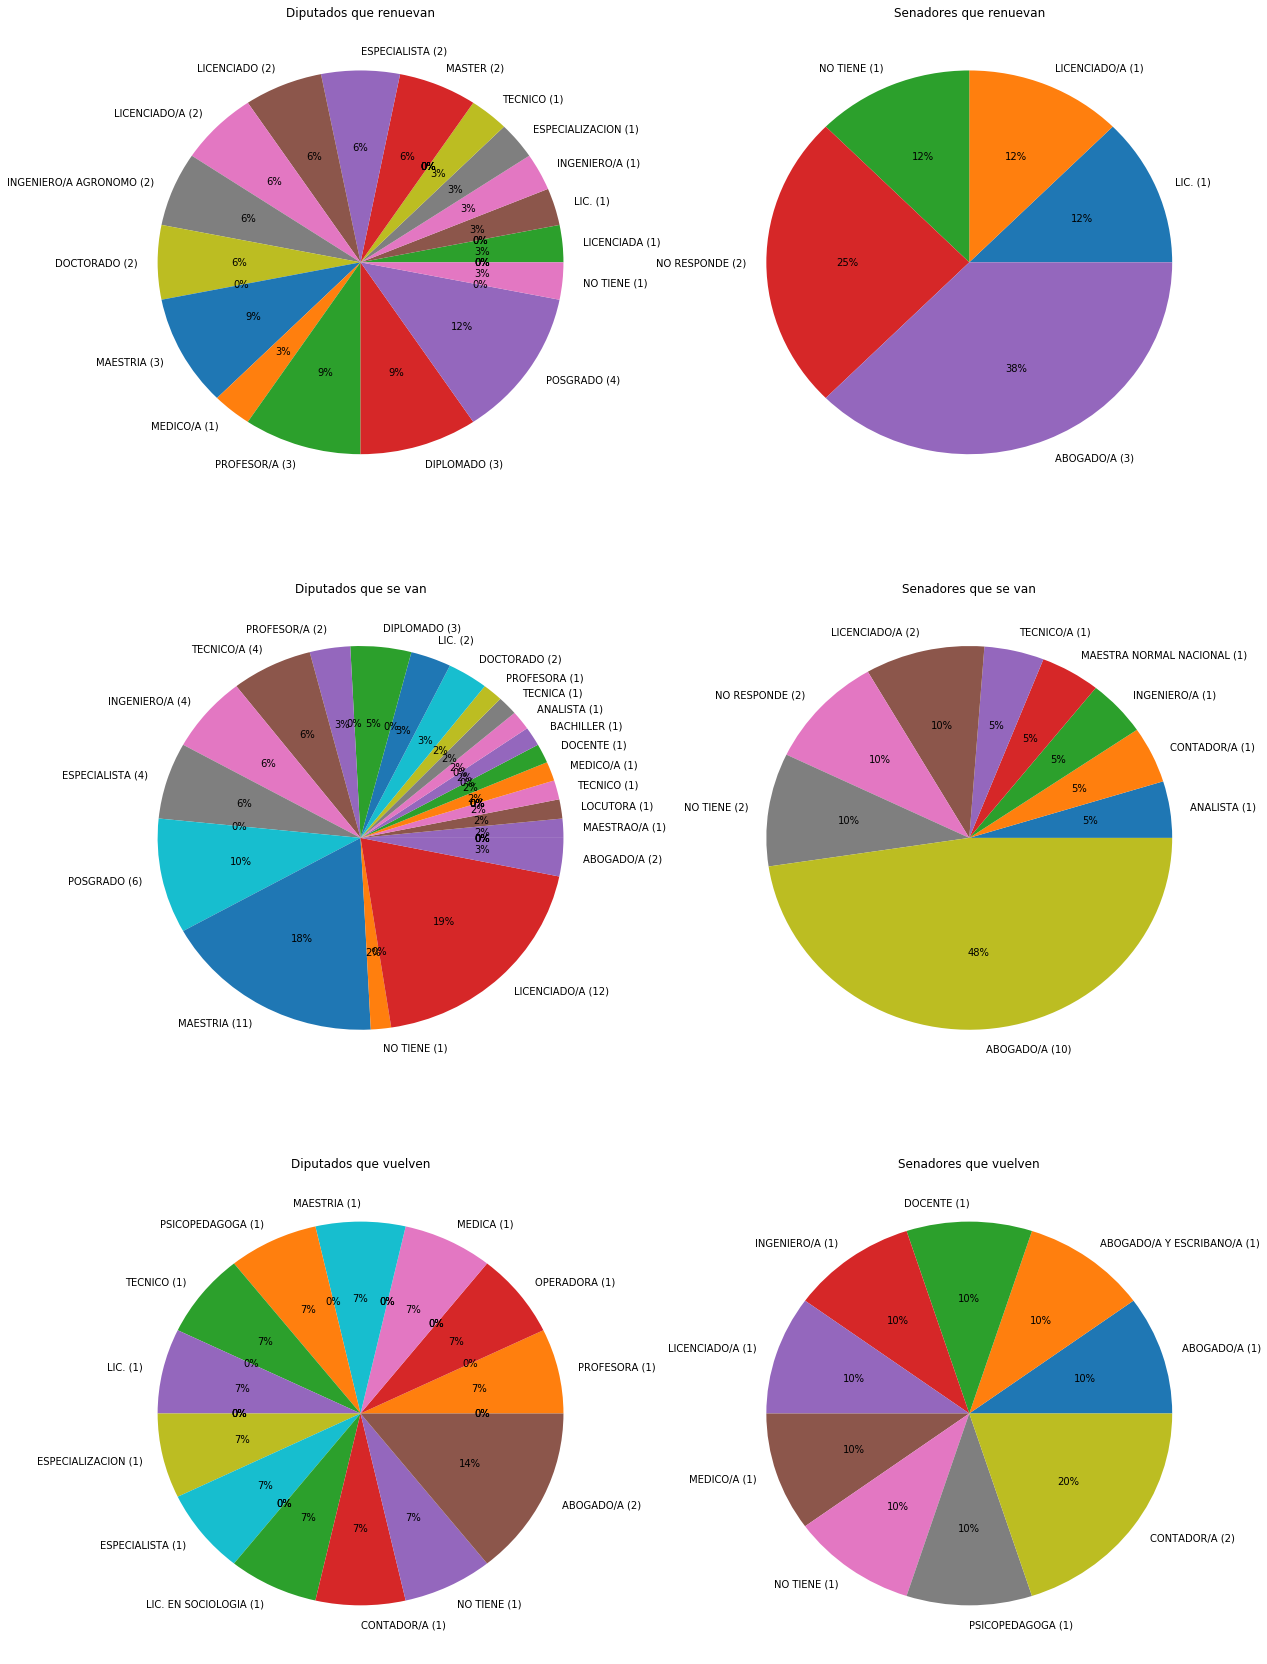

In [19]:
columnas_estudios_dip = [col for col in diputados_todos.columns if col.startswith('estudios')]
columnas_estudios_sen = [col for col in senadores_todos.columns if col.startswith('titulosacademicosobtenidos')]


dip_vig_titulos = normalizarColumnas(diputados_vigente[columnas_estudios_dip])
dip_vig_titulos = dip_vig_titulos.join(diputados_vigente, on='index')

dip_pas_titulos = normalizarColumnas(diputados_pasado[columnas_estudios_dip])
dip_pas_titulos = dip_pas_titulos.join(diputados_pasado, on='index')

graficosDeTorta([3,2,10], [
    {'data': dip_vig_titulos[dip_vig_titulos['grupo'] == 'renueva'],     'groupby': 'estudios_titulo',                  'title': 'Diputados que renuevan'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'renueva'], 'groupby': 'titulosacademicosobtenidos_titul', 'title': 'Senadores que renuevan'},
    {'data': dip_vig_titulos[dip_vig_titulos['grupo'] == 'deja'],        'groupby': 'estudios_titulo',                  'title': 'Diputados que se van'},
    {'data': senadores_vigente[senadores_vigente['grupo'] == 'deja'],    'groupby': 'titulosacademicosobtenidos_titul', 'title': 'Senadores que se van'},
    {'data': dip_pas_titulos[dip_pas_titulos['vuelve']],                 'groupby': 'estudios_titulo',                  'title': 'Diputados que vuelven'},
    {'data': senadores_pasado[senadores_pasado['vuelve']],               'groupby': 'titulosacademicosobtenidos_titul', 'title': 'Senadores que vuelven'}
])

### Universidad

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 21: ordinal not in range(128)

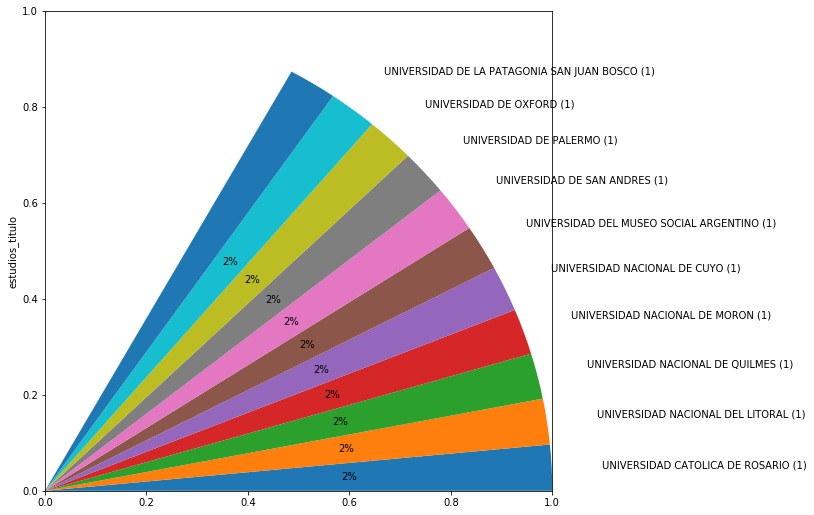

In [20]:
columnas_estudios_dip = [col for col in diputados_todos.columns if col.startswith('estudios')]
columnas_estudios_sen = [col for col in senadores_todos.columns if col.startswith('titulosacademicosobtenidos')]

dip_vig_titulos = normalizarColumnas(diputados_vigente[columnas_estudios_dip])
dip_vig_titulos = dip_vig_titulos.join(diputados_vigente, on='index')

dip_pas_titulos = normalizarColumnas(diputados_pasado[columnas_estudios_dip])
dip_pas_titulos = dip_pas_titulos.join(diputados_pasado, on='index')

# graficosDeTorta([3,2,10], [
#     {'data': dip_vig_titulos[dip_vig_titulos['grupo'] == 'renueva'],     'groupby': 'estudios_institucion',             'title': 'Diputados que renuevan'},
#     {'data': senadores_vigente[senadores_vigente['grupo'] == 'renueva'], 'groupby': 'titulosacademicosobtenidos_insti', 'title': 'Senadores que renuevan'},
#     {'data': dip_vig_titulos[dip_vig_titulos['grupo'] == 'deja'],        'groupby': 'estudios_institucion',             'title': 'Diputados que se van'},
#     {'data': senadores_vigente[senadores_vigente['grupo'] == 'deja'],    'groupby': 'titulosacademicosobtenidos_insti', 'title': 'Senadores que se van'},
#     {'data': dip_pas_titulos[dip_pas_titulos['vuelve']],                 'groupby': 'estudios_institucion',             'title': 'Diputados que vuelven'},
#     {'data': senadores_pasado[senadores_pasado['vuelve']],               'groupby': 'titulosacademicosobtenidos_insti', 'title': 'Senadores que vuelven'}
# ])

In [ ]:
len(diputados) 

In [41]:

# Actividad privada previa
columnas_actprivada_dip = [col for col in diputados.columns if col.startswith('actprivada') and col != 'actprivada_reportaingresosllenar']
# columnas_actprivada_sen = [col for col in diputados.columns if col.startswith('actividadprivadaprevia')]


# Actividad pública previa
# columnas_actpublica_dip = [col for col in diputados.columns if col.startswith('actpublica')]
# columnas_actpublica_sen = [col for col in diputados.columns if col.startswith('actividadpublicaprevia')]


dip_vig_titulos = normalizarColumnas(diputados_vigente[columnas_actprivada_dip])
dip_vig_titulos = dip_vig_titulos.join(diputados_vigente, on='index')

dip_vig_titulos = dip_vig_titulos.fillna('NO TIENE')

insti = dip_vig_titulos.groupby('actprivada_organizacion').count().reset_index()

# insti[insti['actprivada_tipodeactividadcargo'].isin(['0', 'NO TIENE', 'NO RESPONDE'])]
insti.sort_values('index', ascending=False)


# dip_pas_titulos = dip_pas_titulos.join(diputados_pasado, on='index')
# insti[insti['actprivada_organizacion'].str.contains('FUNDACION')]

# len(insti)
# dip_pas_titulos = normalizarColumnas(diputados_pasado[columnas_estudios_dip])
# dip_pas_titulos = dip_pas_titulos.join(diputados_pasado, on='index')


,actprivada_organizacion,index,actprivada_tipodeactividadcargo,actprivada_municipio,actprivada_provincia,actprivada_periodo,nombre,periododeldirectorio,diputado_apellido,diputado_nombre,...,votacionnominal_ndeexpediente2,votacionnominal_tituloproyecto2,v220,votacionnominal_tipovotobloque2,hijos,fecha_limpia,edad,renueva,deja,grupo
102,NO TIENE,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
0,0,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
60,ESTUDIO JURIDICO PROPIO,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
140,UNIVERSIDAD DE BUENOS AIRES,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
138,UNION INDUSTRIAL ARGENTINA,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
59,ESTUDIO JURIDICO PRIVADO,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
149,UNIVERSIDAD NACIONAL DE FORMOSA,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
135,TRIBUNAL DE CUENTAS PROVINCIAL,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
153,UNIVERSIDAD NACIONAL DE SAN LUIS,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
146,UNIVERSIDAD NACIONAL DE CATAMARCA,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [35]:

# Actividad pública previa
columnas_actpublica_dip = [col for col in diputados.columns if col.startswith('actpublica')]
# columnas_actpublica_sen = [col for col in diputados.columns if col.startswith('actividadpublicaprevia')]


dip_vig_titulos = normalizarColumnas(diputados_vigente[columnas_actpublica_dip])
dip_vig_titulos = dip_vig_titulos.join(diputados_vigente, on='index')

dip_vig_titulos = dip_vig_titulos.fillna('NO TIENE')

insti = dip_vig_titulos.groupby('actpublica_cargo').count().reset_index()

# insti[insti['actpublica_cargo'].isin(['0', 'NO TIENE', 'NO RESPONDE'])]
insti


,actpublica_cargo,index,actpublica_especificacioncargo,actpublica_organizacion,actpublica_munprov,actpublica_periodo,nombre,periododeldirectorio,diputado_apellido,diputado_nombre,...,votacionnominal_ndeexpediente2,votacionnominal_tituloproyecto2,v220,votacionnominal_tipovotobloque2,hijos,fecha_limpia,edad,renueva,deja,grupo
0,0,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
1,ADMINISTRADOR,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,AGENTE FISCAL,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,ASESOR,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
4,ASESOR LEGAL,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,ASESORA,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
6,AUDITOR,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,AUDITORA,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
8,AUDITORA GENERAL,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,CONCEJAL,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
